# ITSM Ticket Similarity - Model Fine-tuning (v6 Refactored)

**Version 6 Refactored** improves upon the original v6 by:
1. **Robust Environment Setup:** Automatically handles NLTK data and library dependencies (Kaggle/Local).
2. **Improved Pipeline:** Cleaner data loading and preprocessing.
3. **Contextual Embeddings:** Retains the structured input format `[Service] [Category] Description`.
4. **Reliable Logging:** Auto-detects the best location for logs.


# 1 . Environment Setup

In [1]:
import os, sys, subprocess, pkg_resources
from pathlib import Path

%pip install -q scikit-learn==1.3.2 imbalanced-learn==0.12.0

def ensure_packages(pkgs):
    missing = []
    for name, spec in pkgs.items():
        try:
            pkg_resources.get_distribution(name)
        except pkg_resources.DistributionNotFound:
            missing.append(spec)
    if missing:
        print("📦 Installing:", ", ".join(missing))
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", *missing])

def ensure_nltk(resources=("wordnet","omw-1.4","stopwords","punkt")):
    import nltk
    nltk_data = Path.home() / "nltk_data"
    nltk_data.mkdir(exist_ok=True)
    if str(nltk_data) not in nltk.data.path:
        nltk.data.path.append(str(nltk_data))
    for res in resources:
        try:
            nltk.data.find(f"corpora/{res}")
        except LookupError:
            try:
                nltk.data.find(f"tokenizers/{res}")
            except LookupError:
                print(f"⬇️ Downloading NLTK: {res}")
                nltk.download(res, quiet=True, download_dir=str(nltk_data))

    # 4. Pre-download SentenceTransformer model to cache (avoid runtime download delays)
    try:
        from sentence_transformers import SentenceTransformer
        cache_dir = Path(os.environ.get('TRANSFORMERS_CACHE', Path.home() / '.cache' / 'huggingface' / 'hub'))
        cache_dir.mkdir(parents=True, exist_ok=True)
        os.environ['TRANSFORMERS_CACHE'] = str(cache_dir)
        os.environ['SENTENCE_TRANSFORMERS_HOME'] = str(cache_dir)
        print(f'⬇️ Pre-downloading model to cache: sentence-transformers/all-mpnet-base-v2 -> {cache_dir}')
        SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device='cpu')
        print('✅ Model cached.')
    except Exception as e:
        print(f'⚠️ Model pre-download failed: {e}')

def run_setup():
    os.environ['WANDB_DISABLED'] = 'true'
    os.environ['WANDB_MODE'] = 'offline'
    os.environ['WANDB_SILENT'] = 'true'
    os.environ['HF_HUB_DISABLE_TELEMETRY'] = '1'
    os.environ['TOKENIZERS_PARALLELISM'] = 'false'
    os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

    pkgs = {
        "sentence-transformers": "sentence-transformers",
        "transformers": "transformers",
        "torch": "torch",
        "torchvision": "torchvision",
        "torchaudio": "torchaudio",
        "scikit-learn": "scikit-learn==1.3.2",
        "imbalanced-learn": "imbalanced-learn==0.12.0",
        "scipy": "scipy",
        "numpy": "numpy",
        "pandas": "pandas",
        "tqdm": "tqdm",
        "datasets": "datasets",
        "joblib": "joblib",
        "protobuf": "protobuf<=3.20.1",
        "requests": "requests",
        "python-dotenv": "python-dotenv",
        "openai": "openai",
        "seaborn": "seaborn",
        "matplotlib": "matplotlib",
        "pytorch-lightning": "pytorch-lightning",
    }
    ensure_packages(pkgs)
    ensure_nltk()
    import pkg_resources
    print(pkg_resources.get_distribution("imbalanced-learn").version)
    print(pkg_resources.get_distribution("scikit-learn").version)

run_setup()


/tmp/ipykernel_369/4011613263.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import os, sys, subprocess, pkg_resources


Note: you may need to restart the kernel to use updated packages.
⬇️ Downloading NLTK: wordnet
⬇️ Downloading NLTK: omw-1.4


E0000 00:00:1764577640.642661     369 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764577640.649456     369 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

⬇️ Pre-downloading model to cache: sentence-transformers/all-mpnet-base-v2 -> /root/.cache/huggingface/hub


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ Model cached.
0.12.0
1.3.2


#3. Model Configuration and Loading

In [2]:
import logging
import random
import numpy as np
import torch
if 'log' not in globals() or not callable(log):
    def log(msg, level=logging.INFO):
        print(msg)
# --- CONFIGURATION ---
CONFIG = {
    'model_name': 'sentence-transformers/all-mpnet-base-v2',
    'output_dir': 'models/v6_refactored_finetuned', # New output directory
    'source_data': 'data/dummy_data_promax.csv', # Will try to resolve this
    'relationship_data': 'data/relationship_pairs.json', # For relationship classifier
    
    # Hyperparameters
    'epochs': 1,
    'batch_size': 16,
    'lr': 2e-5,
    'max_seq_length': 384,
    
    # Data Strategy
    'num_pairs': 2000,
    'pos_ratio': 0.4,   # 40% Positive, 60% Negative
    'neg_mining_range': (0.2, 0.5), # TF-IDF score range for "Hard Negatives"
    'eval_split': 0.15, # % of data for validation
    
    # Seed
    'seed': 42
}

# Set Seeds
random.seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
torch.manual_seed(CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG['seed'])
    log(f"🚀 CUDA Detected: {torch.cuda.get_device_name(0)}")
else:
    log("⚠️ CUDA Not Detected. Running on CPU.")


🚀 CUDA Detected: Tesla T4


In [3]:
import pandas as pd
import re
from pathlib import Path
def resolve_data_path(path_str):
    """Smart path resolver for Local/Kaggle/Colab/Agent envs."""
    # 1. As-is
    p = Path(path_str)
    if p.exists(): return p.resolve()
    
    # 2. Relative to current script location (for agent or local execution)
    # Using Path.cwd() as a robust base for notebooks
    script_dir = Path.cwd() 
    if (script_dir / path_str).exists(): return (script_dir / path_str).resolve()

    # 3. Common Kaggle/Colab input paths
    # Assuming path_str might be like 'data/file.csv'
    base_filename = Path(path_str).name
    
    kaggle_input_dir = Path("/kaggle/input")
    if kaggle_input_dir.exists():
        for dataset_dir in kaggle_input_dir.iterdir():
            if (dataset_dir / base_filename).exists():
                return (dataset_dir / base_filename).resolve()
            if (dataset_dir / path_str).exists(): # if path_str includes subdir like 'data/'
                return (dataset_dir / path_str).resolve()
                
    colab_dir = Path("/content")
    if (colab_dir / path_str).exists(): return (colab_dir / path_str).resolve()

    raise FileNotFoundError(f"Could not find {path_str} in any common locations (cwd, relative, Kaggle, Colab).")

def load_and_preprocess_data(config):
    source_path = resolve_data_path(config['source_data'])
    log(f"📂 Loading incident data from: {source_path}")
    df = pd.read_csv(source_path)
    
    # Required columns for contextual embedding
    required_cols = ["Number", "Short Description", "Description", "Category", "Subcategory", 
                     "Service", "Service offering", "Assignment group"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Fill NA and Clean Text
    # We ensure all context fields are strings
    placeholders = {"", "nan", "none", "null", "unknown", "n/a", "na"}

    def normalize_field(val: str) -> str:
        s = str(val).strip()
        s = re.sub(r"\s+", " ", s) # Replace multiple spaces with single
        if s.lower() in placeholders:
            return ""
        return s

    for col in [c for c in required_cols if c != "Number"]:
        df[col] = df[col].fillna("").apply(normalize_field)

    # Normalize casing for structured context fields to reduce duplicates
    context_cols = ["Service", "Service offering", "Category", "Subcategory", "Assignment group"]
    for col in context_cols:
        df[col] = df[col].str.lower()

    # Construct Rich Text Representation (Contextual Prefixing)
    # Format: [Service | Service offering] [Category | Subcategory] Group: Assignment group. Short Description. Description
    def build_bracketed(parts):
        clean_parts = [p for p in parts if p]
        return f"[{ ' | '.join(clean_parts) }] " if clean_parts else "" 

    df['context_service'] = df.apply(lambda row: build_bracketed([row['Service'], row['Service offering']]), axis=1)
    df['context_category'] = df.apply(lambda row: build_bracketed([row['Category'], row['Subcategory']]), axis=1)
    df['context_group'] = df.apply(lambda row: f"Group: {row['Assignment group']}. " if row['Assignment group'] else "", axis=1)

    df['text'] = (
        df['context_service'] +
        df['context_category'] +
        df['context_group'] +
        df['Short Description'].str.strip() + ". " +
        df['Description'].str.strip()
    ).str.replace(r"\\s+\\.", ".", regex=True) # Remove space before period
    df['text'] = df['text'].str.replace(r"\\s+", " ", regex=True).str.strip() # Clean up excess spaces

    # Filter empty or too short
    initial_count = len(df)
    min_length = 10 # Configurable if needed
    df = df[df['text'].str.len() >= min_length].copy()
    dropped = initial_count - len(df)
    if dropped > 0:
        log(f"⚠️ Dropped {dropped} incidents due to short/empty text after preprocessing.")
    
    # Create unique group ID for stratified splitting (Category-Subcategory)
    df['category_id'] = df.groupby(['Category', 'Subcategory']).ngroup()
    
    log(f"✅ Preprocessed {len(df)} incidents.")
    log(f"Sample preprocessed text: '{df['text'].iloc[0]}'")
    df = df.reset_index(drop=True)
    log(f'✅ Index reset. Range: {df.index.min()} to {df.index.max()}')
    return df

df_incidents = load_and_preprocess_data(CONFIG)


📂 Loading incident data from: /kaggle/input/itsm-dataset/dummy_data_promax.csv
✅ Preprocessed 10000 incidents.
Sample preprocessed text: '[crm (d365, salesforce, genesis, pcube, hussmann services) | bc - basis] [configuration | program bug] Group: piscap l2 workflow. Request: Adjust Configuration/Program bug configuration in CRM (D365, SalesForce, Genesis, PCube, HussMann Services). I encountered an issue where Request: Adjust Configuration/Program bug configuration in CRM (D365, SalesForce, Genesis, PCube, HussMann Services). I'd like assistance to investigate and resolve it.'
✅ Index reset. Range: 0 to 9999


In [4]:
from sentence_transformers import InputExample
from tqdm.auto import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
class TextSimilarityCalculator:
    def __init__(self, texts):
        self.lemmatizer = WordNetLemmatizer() if 'wordnet' in nltk.data.path else None
        self.stop_words = set(stopwords.words('english')) if 'stopwords' in nltk.data.path else ENGLISH_STOP_WORDS
        self.vectorizer = TfidfVectorizer(stop_words=list(self.stop_words), max_features=10000)
        
        log("⏳ Fitting TF-IDF for similarity mining...")
        self.tfidf = self.vectorizer.fit_transform(texts)
        log(f"✅ TF-IDF fit complete. Matrix shape: {self.tfidf.shape}")

    def get_tfidf_similarity(self, idx1, idx2):
        if idx1 >= self.tfidf.shape[0] or idx2 >= self.tfidf.shape[0]:
            return 0.0 
        return (self.tfidf[idx1] @ self.tfidf[idx2].T).toarray()[0][0]

def generate_smart_pairs(df, target_count, config):
    """Generates positive and hard negative pairs based on TF-IDF similarity."""
    # Ensure index is reset for direct iloc/loc correspondence
    df = df.reset_index(drop=True)
    
    sim_calculator = TextSimilarityCalculator(df['text'].tolist())

    positive_target = int(target_count * config['pos_ratio'])
    negative_target = target_count - positive_target

    pairs = []
    
    # Group by Category/Subcategory
    # groups indices are now reliable 0..N integers because of reset_index
    groups = df.groupby('category_id').indices 
    valid_groups = {k: list(v) for k, v in groups.items() if len(v) >= 2}
    all_indices = list(df.index)

    log(f"🔎 Generating {positive_target} positive and {negative_target} hard negative pairs...")

    # --- 1. Positive Pairs ---
    pbar_pos = tqdm(total=positive_target, desc="Generating Positives")
    attempts = 0
    while len(pairs) < positive_target and attempts < positive_target * 5:
        attempts += 1
        if not valid_groups: break
        
        gid = random.choice(list(valid_groups.keys()))
        g_idxs = valid_groups[gid] # already a list
        
        if len(g_idxs) < 2: continue
        
        i1, i2 = random.sample(g_idxs, 2)
        
        # i1, i2 are integer positions. Since we reset index, they are also labels.
        # Using iloc is safest for 'text' column access if we mix things up, 
        # but here loc==iloc. We use simple integer indexing for tfidf.
        
        sim = sim_calculator.get_tfidf_similarity(i1, i2)
        
        if sim > 0.3:
            pairs.append(InputExample(texts=[df.at[i1, 'text'], df.at[i2, 'text']], label=1.0))
            pbar_pos.update(1)
            
    # Fill remaining positives
    if len(pairs) < positive_target:
        log(f"⚠️ Filling {positive_target - len(pairs)} remaining positives with random in-group pairs.")
        while len(pairs) < positive_target:
            if not valid_groups: break
            gid = random.choice(list(valid_groups.keys()))
            g_idxs = valid_groups[gid]
            if len(g_idxs) < 2: continue
            i1, i2 = random.sample(g_idxs, 2)
            pairs.append(InputExample(texts=[df.at[i1, 'text'], df.at[i2, 'text']], label=1.0))
            pbar_pos.update(1)
            
    pbar_pos.close()

    # --- 2. Hard Negative Pairs ---
    current_pos_count = len(pairs)
    pbar_neg = tqdm(total=negative_target, desc="Generating Negatives")
    attempts = 0
    max_attempts = negative_target * 10 
    
    while (len(pairs) - current_pos_count) < negative_target and attempts < max_attempts:
        attempts += 1
        
        i1, i2 = random.sample(all_indices, 2)
        
        if df.at[i1, 'category_id'] == df.at[i2, 'category_id']:
            continue
            
        sim = sim_calculator.get_tfidf_similarity(i1, i2)
        
        min_sim, max_sim = config['neg_mining_range']
        if min_sim <= sim <= max_sim:
            pairs.append(InputExample(texts=[df.at[i1, 'text'], df.at[i2, 'text']], label=0.0))
            pbar_neg.update(1)
            
    # Fill remaining negatives
    neg_generated = len(pairs) - current_pos_count
    if neg_generated < negative_target:
         log(f"⚠️ Filling {negative_target - neg_generated} remaining negatives with random cross-category pairs.")
         while (len(pairs) - current_pos_count) < negative_target:
            i1, i2 = random.sample(all_indices, 2)
            if df.at[i1, 'category_id'] != df.at[i2, 'category_id']:
                pairs.append(InputExample(texts=[df.at[i1, 'text'], df.at[i2, 'text']], label=0.0))
                pbar_neg.update(1)
                
    pbar_neg.close()
    
    log(f"✅ Generated {len(pairs)} training pairs.")
    return pairs

# Split incidents into train/eval sets for pair generation
# Note: we split BEFORE pair generation, so we must reset index on the splits individually
train_incidents_df, eval_incidents_df = train_test_split(
    df_incidents,
    test_size=CONFIG['eval_split'],
    stratify=df_incidents['category_id'],
    random_state=CONFIG['seed']
)

log(f"Split Incidents: Train={len(train_incidents_df)}, Eval={len(eval_incidents_df)}")

# Calculate target pairs for each split
train_num_pairs = int(CONFIG['num_pairs'] * (1 - CONFIG['eval_split']))
eval_num_pairs = CONFIG['num_pairs'] - train_num_pairs

train_examples = generate_smart_pairs(train_incidents_df, train_num_pairs, CONFIG)
eval_examples = generate_smart_pairs(eval_incidents_df, eval_num_pairs, CONFIG)

log(f"Final Samples: Training={len(train_examples)}, Evaluation={len(eval_examples)}")



Split Incidents: Train=8500, Eval=1500
⏳ Fitting TF-IDF for similarity mining...
✅ TF-IDF fit complete. Matrix shape: (8500, 110)
🔎 Generating 680 positive and 1020 hard negative pairs...


Generating Positives:   0%|          | 0/680 [00:00<?, ?it/s]

Generating Negatives:   0%|          | 0/1020 [00:00<?, ?it/s]

✅ Generated 1700 training pairs.
⏳ Fitting TF-IDF for similarity mining...
✅ TF-IDF fit complete. Matrix shape: (1500, 110)
🔎 Generating 120 positive and 180 hard negative pairs...


Generating Positives:   0%|          | 0/120 [00:00<?, ?it/s]

Generating Negatives:   0%|          | 0/180 [00:00<?, ?it/s]

✅ Generated 300 training pairs.
Final Samples: Training=1700, Evaluation=300


In [5]:
import torch, os, subprocess
print("cuda?", torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    subprocess.run(["nvidia-smi"])

os.environ["TRANSFORMERS_CACHE"] = "/kaggle/working/hf_cache"



cuda? True
Tesla T4
Mon Dec  1 08:27:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P8             11W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------------

In [6]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_auc_score, average_precision_score
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from datetime import datetime
from sentence_transformers.evaluation import SentenceEvaluator
# --- Model Evaluation Class ---
class ITSMEvaluator(SentenceEvaluator):
    def __init__(self, examples: list[InputExample], batch_size: int = 16, name: str = ''):
        self.examples = examples
        self.batch_size = batch_size
        self.name = name

        self.texts1 = [ex.texts[0] for ex in examples]
        self.texts2 = [ex.texts[1] for ex in examples]
        self.labels = np.array([ex.label for ex in examples])

        self.csv_file = f"{name}_eval_results.csv"
        self.csv_headers = ['epoch', 'steps', 'spearman', 'pearson', 'roc_auc', 'pr_auc']

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:
        model.eval()
        log(f"📊 Running evaluation at epoch={epoch}, step={steps}...", level=logging.DEBUG)

        # Encode all texts
        embeddings1 = model.encode(self.texts1, batch_size=self.batch_size, show_progress_bar=False, convert_to_numpy=True)
        embeddings2 = model.encode(self.texts2, batch_size=self.batch_size, show_progress_bar=False, convert_to_numpy=True)

        # Calculate cosine similarities
        cosine_scores = np.sum(embeddings1 * embeddings2, axis=1) / (np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1))

        # Calculate metrics
        eval_pearson, _ = pearsonr(self.labels, cosine_scores)
        eval_spearman, _ = spearmanr(self.labels, cosine_scores)

        try:
            roc_auc = roc_auc_score(self.labels, cosine_scores)
            pr_auc = average_precision_score(self.labels, cosine_scores)
        except ValueError:
            roc_auc = 0.0
            pr_auc = 0.0
            log('⚠️ ROC/PR AUC cannot be calculated due to single class in evaluation labels.', level=logging.WARNING)

        log_msg = (
            f"Epoch {epoch if epoch != -1 else 'N/A'} Steps {steps if steps != -1 else 'N/A'}: "
            f"Spearman={eval_spearman:.4f}, Pearson={eval_pearson:.4f}, "
            f"ROC_AUC={roc_auc:.4f}, PR_AUC={pr_auc:.4f}"
        )
        log(log_msg)

        if output_path is not None:
            csv_path = Path(output_path) / self.csv_file
            output_data = [epoch, steps, eval_spearman, eval_pearson, roc_auc, pr_auc]

            if not csv_path.is_file():
                with open(csv_path, 'w', encoding='utf-8') as f:
                    f.write(','.join(self.csv_headers) + '\n')

            with open(csv_path, 'a', encoding='utf-8') as f:
                f.write(','.join(map(str, output_data)) + '\n')

        return eval_spearman

# --- Model Setup ---
# Select device (prefer CUDA, then MPS, else CPU)
device = 'cuda' if torch.cuda.is_available() else 'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else 'cpu'
log(f'🔌 Using device: {device}')

model = SentenceTransformer(CONFIG['model_name'], device=device)
model.max_seq_length = CONFIG['max_seq_length']

log(f'✅ Model initialized on device: {device}. Max seq len: {model.max_seq_length}')
pin_memory = device == 'cuda'
num_workers = 2
train_loss = losses.CosineSimilarityLoss(model)
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=CONFIG['batch_size'], num_workers=num_workers, pin_memory=pin_memory)
log(f'📊 Train batches: {len(train_dataloader)}, Eval examples: {len(eval_examples)}')

evaluator = ITSMEvaluator(eval_examples, batch_size=CONFIG['batch_size'], name='validation')

# --- Training Execution ---
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
save_path = Path(CONFIG['output_dir']) / f"{Path(CONFIG['output_dir']).name}_{timestamp}"
save_path.mkdir(parents=True, exist_ok=True)

log(f"🚀 Starting training... Model will be saved to: {save_path}")
log(f"🚦 Ready to train: batches={len(train_dataloader)}, epochs={CONFIG['epochs']}, batch_size={CONFIG['batch_size']}, device={device}")

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=CONFIG['epochs'],
    warmup_steps=int(len(train_dataloader) * CONFIG['epochs'] * 0.1),
    optimizer_params={'lr': CONFIG['lr']},
    output_path=str(save_path),
    evaluation_steps=int(len(train_dataloader) * CONFIG['epochs'] * 0.1),
    save_best_model=True,
    show_progress_bar=True
)
log('model.fit finished')
log('Training complete.')

# --- Final Evaluation ---
log('✨ Reloading best model for final evaluation...')
best_model = SentenceTransformer(str(save_path))

final_evaluator = ITSMEvaluator(eval_examples, batch_size=CONFIG['batch_size'], name='final_evaluation')
final_spearman = final_evaluator(best_model, output_path=str(save_path), epoch='final', steps='final')

log(f'Final Model (best) saved to: {save_path}')


🔌 Using device: cuda
✅ Model initialized on device: cuda. Max seq len: 384
📊 Train batches: 107, Eval examples: 300
🚀 Starting training... Model will be saved to: models/v6_refactored_finetuned/v6_refactored_finetuned_20251201_0827
🚦 Ready to train: batches=107, epochs=1, batch_size=16, device=cuda


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Evaluator
10,No log,No log,0.665627
20,No log,No log,0.839262
30,No log,No log,0.847983
40,No log,No log,0.848533
50,No log,No log,0.848533
54,No log,No log,0.848533


📊 Running evaluation at epoch=0.18518518518518517, step=10...
Epoch 0.18518518518518517 Steps 10: Spearman=0.6656, Pearson=0.6839, ROC_AUC=0.8922, PR_AUC=0.8815
📊 Running evaluation at epoch=0.37037037037037035, step=20...
Epoch 0.37037037037037035 Steps 20: Spearman=0.8393, Pearson=0.8812, ROC_AUC=0.9945, PR_AUC=0.9925
📊 Running evaluation at epoch=0.5555555555555556, step=30...
Epoch 0.5555555555555556 Steps 30: Spearman=0.8480, Pearson=0.9034, ROC_AUC=0.9997, PR_AUC=0.9995
📊 Running evaluation at epoch=0.7407407407407407, step=40...
Epoch 0.7407407407407407 Steps 40: Spearman=0.8485, Pearson=0.9135, ROC_AUC=1.0000, PR_AUC=1.0000
📊 Running evaluation at epoch=0.9259259259259259, step=50...
Epoch 0.9259259259259259 Steps 50: Spearman=0.8485, Pearson=0.9154, ROC_AUC=1.0000, PR_AUC=1.0000
📊 Running evaluation at epoch=1.0, step=54...
Epoch 1.0 Steps 54: Spearman=0.8485, Pearson=0.9155, ROC_AUC=1.0000, PR_AUC=1.0000
model.fit finished
Training complete.
✨ Reloading best model for final e

📊 Eval: ROC_AUC=1.0000, PR_AUC=1.0000, F1@best=0.9959, P@best=0.9917, R@best=1.0000, Acc=0.9967, Thresh=0.642


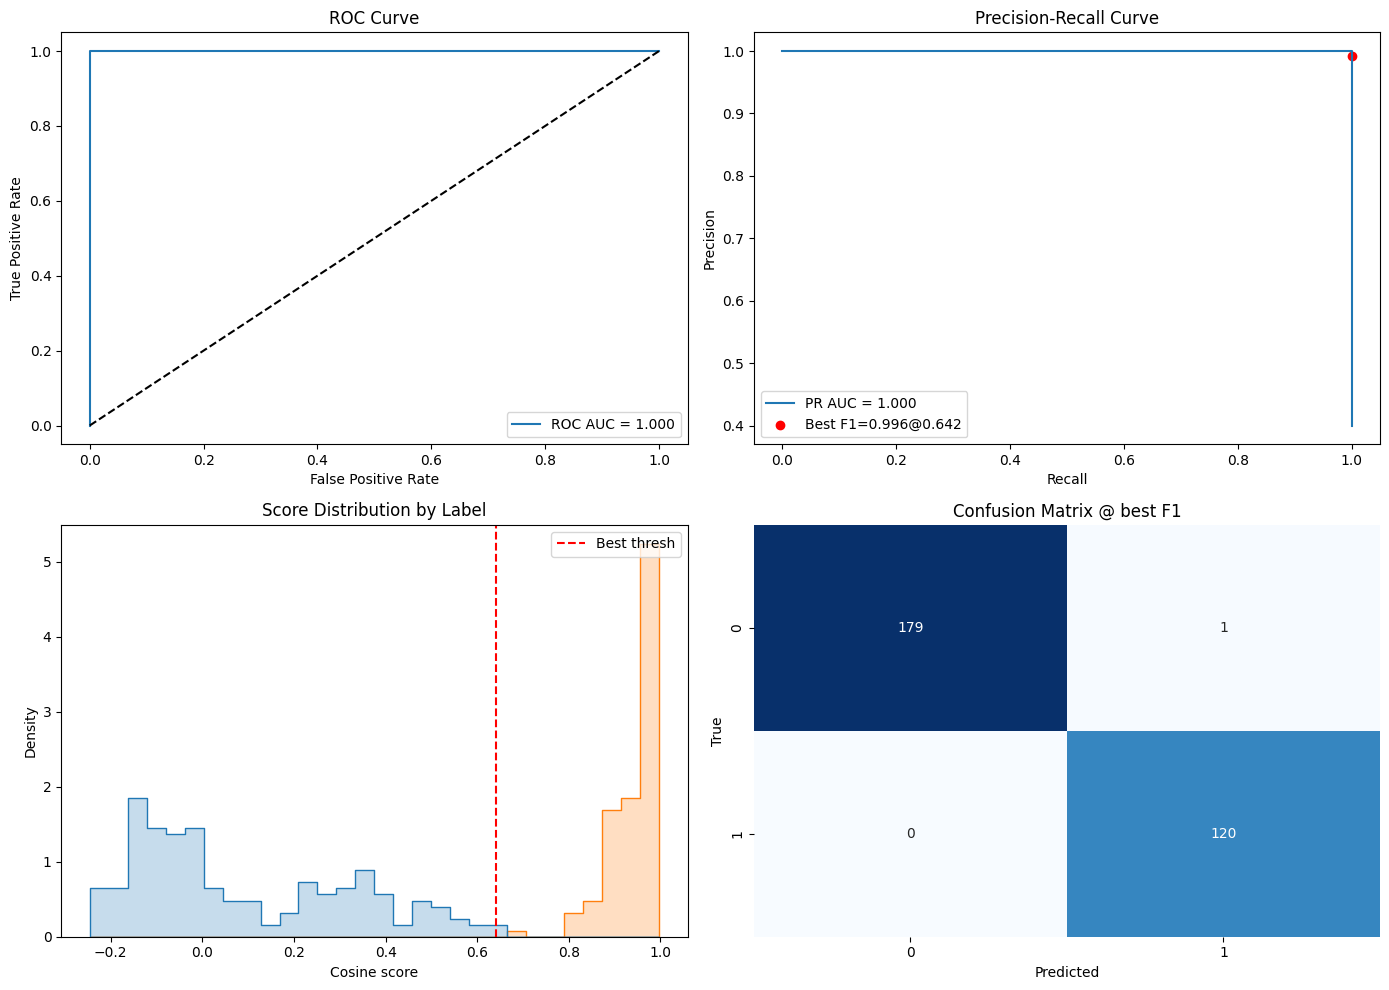

In [7]:

# --- Evaluation Metrics & Plots ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
)

if 'best_model' not in globals():
    best_model = SentenceTransformer(str(save_path))

texts1 = [ex.texts[0] for ex in eval_examples]
texts2 = [ex.texts[1] for ex in eval_examples]
labels = np.array([ex.label for ex in eval_examples])

emb1 = best_model.encode(texts1, batch_size=CONFIG['batch_size'], show_progress_bar=False, convert_to_numpy=True)
emb2 = best_model.encode(texts2, batch_size=CONFIG['batch_size'], show_progress_bar=False, convert_to_numpy=True)
cosine_scores = np.sum(emb1 * emb2, axis=1) / (np.linalg.norm(emb1, axis=1) * np.linalg.norm(emb2, axis=1))

roc_auc = roc_auc_score(labels, cosine_scores)
pr_auc = average_precision_score(labels, cosine_scores)
fpr, tpr, roc_thresh = roc_curve(labels, cosine_scores)
precision, recall, pr_thresh = precision_recall_curve(labels, cosine_scores)

f1_candidates = 2 * (precision * recall) / (precision + recall + 1e-12)
best_idx = int(np.nanargmax(f1_candidates))
best_thresh = pr_thresh[best_idx-1] if 0 < best_idx < len(pr_thresh)+1 else 0.5
preds = (cosine_scores >= best_thresh).astype(int)
prec_at_best = precision_score(labels, preds)
rec_at_best = recall_score(labels, preds)
f1_at_best = f1_score(labels, preds)
acc_at_best = accuracy_score(labels, preds)
cm = confusion_matrix(labels, preds)

log(
    f"📊 Eval: ROC_AUC={roc_auc:.4f}, PR_AUC={pr_auc:.4f}, "
    f"F1@best={f1_at_best:.4f}, P@best={prec_at_best:.4f}, R@best={rec_at_best:.4f}, "
    f"Acc={acc_at_best:.4f}, Thresh={best_thresh:.3f}"
)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# ROC
axes[0,0].plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
axes[0,0].plot([0,1],[0,1],'k--')
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curve')
axes[0,0].legend()
# PR
axes[0,1].plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
axes[0,1].scatter(rec_at_best, prec_at_best, color='red', label=f"Best F1={f1_at_best:.3f}@{best_thresh:.3f}")
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision-Recall Curve')
axes[0,1].legend()
# Score distribution by label
sns.histplot(x=cosine_scores, hue=labels, bins=30, stat='density', element='step', ax=axes[1,0])
axes[1,0].axvline(best_thresh, color='red', linestyle='--', label='Best thresh')
axes[1,0].set_title('Score Distribution by Label')
axes[1,0].set_xlabel('Cosine score')
axes[1,0].legend()
# Confusion matrix at best threshold
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1,1])
axes[1,1].set_title('Confusion Matrix @ best F1')
axes[1,1].set_xlabel('Predicted')
axes[1,1].set_ylabel('True')

plt.tight_layout()
plt.show()


In [9]:

import json

# --- Relationship Classifier (Optional) ---
# Runs only if imbalanced-learn is available and relationship data exists.
try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
except ImportError:
    IMBLEARN_AVAILABLE = False

if IMBLEARN_AVAILABLE:
    rel_data_path = None
    try:
        rel_data_path = resolve_data_path(CONFIG['relationship_data'])
    except FileNotFoundError:
        log(f"⚠️ Relationship data not found at {CONFIG['relationship_data']}. Skipping classifier training.", level=logging.WARNING)

    if rel_data_path and rel_data_path.exists():
        log('🧠 Training Relationship Classifier...')
        with open(rel_data_path, 'r') as f:
            rel_data = json.load(f)

        rel_df = pd.DataFrame(rel_data)
        valid_labels = ['duplicate', 'causal', 'related', 'none']
        rel_df = rel_df[rel_df['label'].isin(valid_labels)]
        log(f"Relationship samples after filtering: {len(rel_df)}")
        
        show_progress = True
        
        if len(rel_df) > 0:
            text_a = rel_df['text_a'].tolist()
            text_b = rel_df['text_b'].tolist()

            log("⏳ Encoding relationship data with the best model...")
            emb_a = best_model.encode(text_a, batch_size=CONFIG['batch_size'], show_progress_bar=False)
            emb_b = best_model.encode(text_b, batch_size=CONFIG['batch_size'], show_progress_bar=False)

            # Feature Engineering: (u, v, |u-v|, u*v)
            X = np.hstack([emb_a, emb_b, np.abs(emb_a - emb_b), emb_a * emb_b])
            y = rel_df['label']

            from sklearn.linear_model import LogisticRegression
            from sklearn.model_selection import train_test_split
            from sklearn.metrics import classification_report

            if len(np.unique(y)) > 1 and len(X) > 1 and len(np.unique(y)) < len(X):
                smote = SMOTE(k_neighbors=min(2, len(X) - 1), random_state=CONFIG['seed'])
                X_res, y_res = smote.fit_resample(X, y)
                log(f"After SMOTE: {len(X_res)} samples")
            else:
                X_res, y_res = X, y
                log("⚠️ Skipping SMOTE due to insufficient samples or single class after filtering.", level=logging.WARNING)

            clf = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=CONFIG['seed'], solver='lbfgs')
            X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=CONFIG['seed'], stratify=y_res)

            log("⏳ Training Logistic Regression classifier...")
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            log("✅ Relationship Classifier Report:")
            log(f"{classification_report(y_test, y_pred)}")

            import joblib
            classifier_save_path = save_path / "relationship_classifier.joblib"
            joblib.dump(clf, classifier_save_path)
            log(f"✅ Relationship classifier saved to: {classifier_save_path}")
        else:
            log("⚠️ No valid relationship samples to train classifier. Skipping.", level=logging.WARNING)
    else:
        log(f"⚠️ Relationship data not found at resolved path '{rel_data_path}'. Skipping classifier training.", level=logging.WARNING)
else:
    log('⚠️ imbalanced-learn not installed. Skipping relationship classifier.', level=logging.WARNING)


🧠 Training Relationship Classifier...
Relationship samples after filtering: 861575
⏳ Encoding relationship data with the best model...


KeyboardInterrupt: 